# Generative Painting Style Using Generative Adversarial Networks (GANs)

---

This project derives from the Kaggle competition with the name Gan Getting Started (I'm Something of a Painter Myself), found here: https://www.kaggle.com/competitions/gan-getting-started/overview

You can find this project at the github repo: https://github.com/chill0121/Kaggle_Projects/tree/main/Adversarial_Painting

## Table of Contents <a name="toc"></a>

---

- 1.[**Data Source Information**](#datasource)
  - 1.1. [Dataset Information](#data)
  - 1.2. [Kaggle Information](#kaggle)
- 2.[**Setup**](#setup)
  - 2.1. [Environment Details for Reproducility](#env)
  - 2.2. [Importing the Data](#dataimport)
- 3.[**Data Preprocessing**](#datapre)
  - 3.1. [First Looks](#firstlook)
  - 3.2. [Image Augmentation](#aug)
- 4.[**Exploratory Data Analysis (EDA)**](#eda)
- 5.[**Models**](#models)
  - 5.1. [Model Helper Functions](#helper)
  - 5.2. [Generative Adversarial Network (GAN)](#gan)
- 6.[**Results**](#results)
- 7.[**Conclusion - Kaggle Submission Test Set**](#conclusion)
  - 7.1. [Possible Areas for Improvement](#improvements)

- [**Appendix A - Online References**](#appendixa)

## 1. Data Source Information <a name="datasource"></a>

---


### 1.1. Data Information: <a name="data"></a>

Color images (256 x 256 pixels) extracted from histopathologic scans of lymph node sections. These 96 x 96 images are patches of a whole slide image.

- The monet directories contain Monet paintings used to train the model.
- The photo directories contain photos used to add the Monet-style to them for submission.

**Data Info:**
- 300 Monet Painting Images
    - 256 x 256 x 3
- 7028 Photos
    - 256 x 256 x 3

### 1.2. Kaggle Information: <a name="kaggle"></a>

#### Description:

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

#### Evaluation:

MiFID
Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better your generated images are.

What is FID?
Originally published here ([github](https://arxiv.org/abs/1706.08500)), FID, along with Inception Score (IS), are both commonly used in recent publications as the standard for evaluation methods of GANs.

#### Citation: 

Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

###### [Back to Table of Contents](#toc)

## 2. Setup <a name="setup"></a>

---

In [694]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch

###### [Back to Table of Contents](#toc)

### 2.1. Environment Information for Reproducibility: <a name="env"></a>

In [695]:
print(f"Python version: {sys.version}")

packages = [pd, np, sns, sklearn, tf, torch]
for package in packages:
    print(f"{str(package).partition('from')[0]} using version: {package.__version__}")

Python version: 3.11.9 (main, Apr  2 2024, 08:25:04) [Clang 15.0.0 (clang-1500.3.9.4)]
<module 'pandas'  using version: 2.1.4
<module 'numpy'  using version: 1.26.4
<module 'seaborn'  using version: 0.13.2
<module 'sklearn'  using version: 1.3.2
<module 'tensorflow'  using version: 2.16.2
<module 'torch'  using version: 2.2.2


###### [Back to Table of Contents](#toc)

### 2.2. Importing the Data: <a name="dataimport"></a>

In [696]:
# Set directories
current_wdir = os.getcwd()
data_folder = current_wdir + '/Data/'

In [697]:
img_size = 64
batch_size = 16
rand_seed = 11

monet = tf.keras.utils.image_dataset_from_directory(f"{data_folder}/monet_jpg", 
                                                      label_mode = None, 
                                                      image_size = (img_size, img_size), 
                                                      batch_size = batch_size)
# monet = monet.map(lambda x: x / 255.0)
monet = monet.map(lambda x: (x / 127.5) - 1 )

Found 300 files.


###### [Back to Table of Contents](#toc)

## 3. Data Preprocessing <a name="datapre"></a>

---

### 3.1. First Looks: <a name="firstlook"></a>

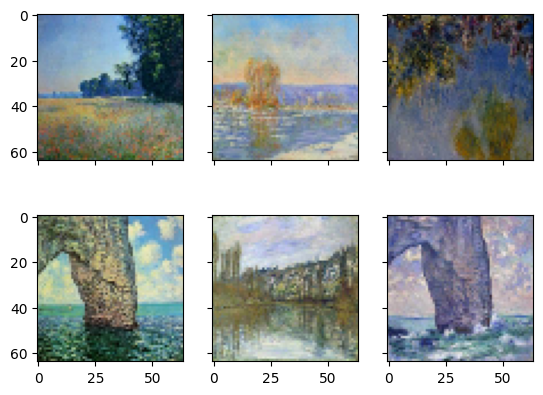

In [698]:
for img in monet:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = ((img.numpy() + 1) * 127.5).astype(np.uint8)
    ax[0,0].imshow(img[0])
    ax[0,1].imshow(img[1])
    ax[0,2].imshow(img[2])
    ax[1,0].imshow(img[3])
    ax[1,1].imshow(img[4])
    ax[1,2].imshow(img[5])
    break

### 3.2. Image Augmentation: <a name="aug"></a>

In [699]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomCrop(img_size, img_size)])

In [700]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle = False, augment = False):
  if shuffle:
    ds = ds.shuffle(1000)

  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls = AUTOTUNE)

  # Prefetch necessary here.
  return ds.prefetch(buffer_size = AUTOTUNE)

In [701]:
monet_transformed = prepare(monet, shuffle = True, augment = True)

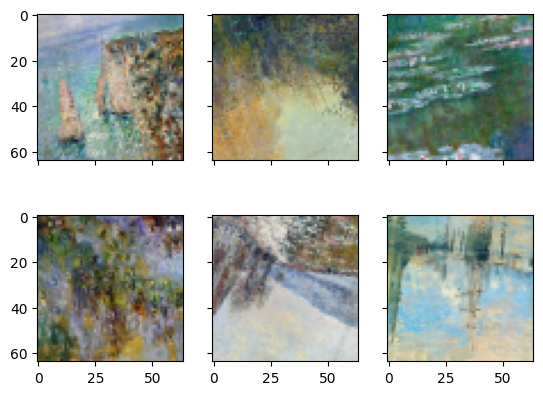

In [702]:
for img in monet_transformed:
    fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
    img = ((img.numpy() + 1) * 127.5).astype(np.uint8)
    ax[0,0].imshow(img[0])
    ax[0,1].imshow(img[1])
    ax[0,2].imshow(img[2])
    ax[1,0].imshow(img[3])
    ax[1,1].imshow(img[4])
    ax[1,2].imshow(img[5])
    break

###### [Back to Table of Contents](#toc)

## 4. Exploratory Data Analysis (EDA) <a name="eda"></a>

---

###### [Back to Table of Contents](#toc)

## 5. Models <a name="models"></a>

---

###### [Back to Table of Contents](#toc)

### 5.1. Model Helper Functions <a name="helper"></a>

###### [Back to Table of Contents](#toc)

### 5.2. Generative Adversarial Network (GAN) <a name="gan"></a>

In [703]:
latent_dim = 512
epochs = 50
num_img_saved = 3

Since we're using Binary Cross Entropy as the loss function, the last layer will use a sigmoid activation function.

In [704]:
discriminator = tf.keras.Sequential(
    [tf.keras.Input(shape = (img_size, img_size, 3)),
     tf.keras.layers.Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
     #tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1, activation = 'sigmoid')],
     name = 'Discriminator')

discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_150 (Conv2D)             │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_242 (LeakyReLU)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_170         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_243 (LeakyReLU)     │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_171         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_244 (LeakyReLU)     │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_172         │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_245 (LeakyReLU)     │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927,297 (3.54 MB)

 Trainable params: 926,273 (3.53 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [705]:
generator = tf.keras.Sequential(
    [tf.keras.Input(shape = (latent_dim, )),
     tf.keras.layers.Dense(4 * 4 * latent_dim),
     tf.keras.layers.Reshape((4, 4, latent_dim)),
     tf.keras.layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
     #tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.LeakyReLU(negative_slope = 0.2),
     tf.keras.layers.Conv2D(3, kernel_size = 5, padding = 'same', activation = 'tanh')],
     name = 'Generator')
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 8192)           │     4,202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_43 (Reshape)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_134            │ (None, 8, 8, 256)      │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_246 (LeakyReLU)     │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_135            │ (None, 16, 16, 256)    │     1,048,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_173         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_247 (LeakyReLU)     │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_136            │ (None, 32, 32, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_174         │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_248 (LeakyReLU)     │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_137            │ (None, 64, 64, 512)    │     4,194,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_175         │ (None, 64, 64, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_249 (LeakyReLU)     │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,684,739 (52.20 MB)

 Trainable params: 13,682,179 (52.19 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [706]:
# GAN Class was altered from https://keras.io/examples/generative/dcgan_overriding_train_step/
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # self.seed_generator = tf.keras.random.SeedGenerator(rand_seed)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name = "D_Loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name = "G_Loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space.
        batch_size = tf.keras.ops.shape(real_images)[0]
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim))#, seed=self.seed_generator)

        # Decode the latent space to a fake image.
        generated_images = self.generator(random_latent_vectors)

        # Zip with real images.
        combined_images = tf.keras.ops.concatenate([generated_images, real_images], axis=0)

        # # Assemble labels discriminating real from fake images.
        # labels = tf.keras.ops.concatenate([tf.keras.ops.ones((batch_size, 1)), tf.keras.ops.zeros((batch_size, 1))], axis=0)
        
        # # Add noise to labels.
        # labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Create labels for real (1) and fake (0) images
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Apply label smoothing: change real labels from 1 to a value like 0.9
        smoothed_real_labels = real_labels * 0.9  # Real label smoothing
        combined_labels = tf.concat([smoothed_real_labels, fake_labels], axis=0)

        # Add some noise to the labels (optional but can help)
        combined_labels += 0.05 * tf.random.uniform(tf.shape(combined_labels))

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(combined_labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.keras.random.normal(
            shape=(batch_size, self.latent_dim))#, seed=self.seed_generator)

        # Assemble misleading labels that show all real images.
        misleading_labels = tf.keras.ops.zeros((batch_size, 1))

        # Train the generator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update loss metrics.
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [707]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim
        # self.seed_generator = tf.keras.random.SeedGenerator(rand_seed)

    # Save a few generated images at each epoch.
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.keras.random.normal(
            shape=(self.num_img, self.latent_dim))#, seed=self.seed_generator)
        generated_images = self.model.generator(random_latent_vectors, training = False)
        #generated_images *= 255
        generated_images = (generated_images + 1) * 127.5
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save(f"{current_wdir}/Generated_Images/{epoch+1:03}_{i}.jpg")

In [708]:
gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.5, beta_2 = 0.9),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9),
    loss_fn = tf.keras.losses.BinaryCrossentropy())

history_gan = gan.fit(monet_transformed, epochs = epochs, callbacks = [GANMonitor(num_img = num_img_saved, latent_dim = latent_dim)])

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - d_loss: 0.6780 - g_loss: 0.7192
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - d_loss: 0.7018 - g_loss: 0.6989
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - d_loss: 0.8793 - g_loss: 0.6042
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - d_loss: 0.6875 - g_loss: 0.7068
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - d_loss: 0.6956 - g_loss: 0.9103
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - d_loss: 0.6356 - g_loss: 0.9501
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - d_loss: 0.6207 - g_loss: 1.3431
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - d_loss: 0.5613 - g_loss: 1.1982
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - d_loss: 0.5563 - g_loss: 0.9521
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - d_loss: 0.6328 - g_loss: 0.9927
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - d_loss: 0.7343 - g_loss: 0.8534
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - d_loss: 0.7301 - g_lo

Methods Attempted to Mitigate Mode Collapse:

- Batch Normalization
- Layer Normalization
- Deeper Generator and Discriminator Networks
- Larger Latent Space (128 > 256 > 512)
- Different Filter Sizes
- One-Sided Label Smoothing for the Discriminator
- Remove All Seeds for Latent Vector Initialization
- Adjust Beta 1 and 2 on Optimizers for Generator and Discriminator
- Raise Learning Rate on Generator, leaving Discriminators at 0.0001.

Too Try:

- Self-Modulation Layers instead of Batch Norm
- SDG instead of Adam
- Mini-batch
- Add More Dropout to Discriminator

Also To Do Before Kaggle Run:
- Save history
- Save model??

###### [Back to Table of Contents](#toc)

## 6. Results <a name="results"></a>

---

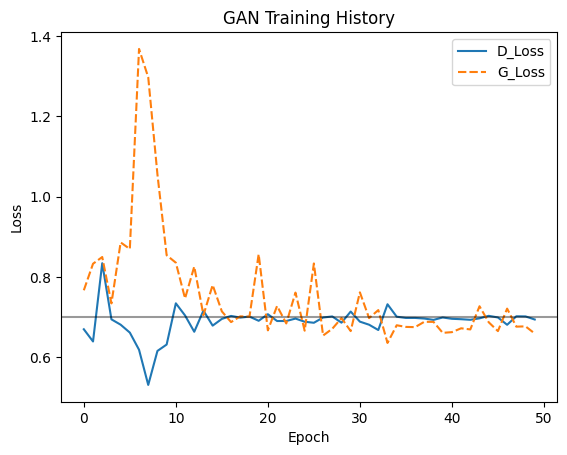

In [709]:
history_gan_df = pd.DataFrame({'D_Loss': history_gan.history['d_loss'], 'G_Loss': history_gan.history['g_loss']})

sns.lineplot(history_gan_df)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training History')
plt.axhline(y = 0.7, c = 'k', alpha = 0.4)
plt.show()

In [710]:
gen_images_files = os.listdir(f"{current_wdir}/Generated_Images")
gen_images = {}

for file in gen_images_files:
    # Skip non-image files.
    if '.jpg' not in file:
        continue
    # Separate epoch number, image number, and file extension.
    epoch, _ = file.split('_')
    if '0' not in _:
        continue
    img = Image.open(f"{current_wdir}/Generated_Images/{file}")
    gen_images[epoch] = np.asarray(img)

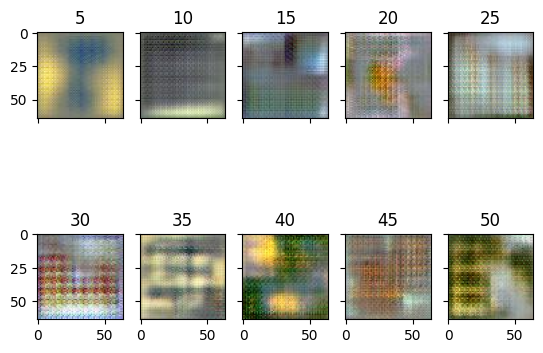

In [711]:
# int((len(range(5, epochs+1, 5)) / 5))
fig, ax = plt.subplots(int((len(range(5, epochs+1, 5)) / 5)), 5, sharex = True, sharey = True)
for i, idx in enumerate(range(5, epochs+1, 5)):
    ax[i // 5, i % 5].imshow(gen_images[f'{str(idx).zfill(3)}'])
    ax[i // 5, i % 5].set_title(f'{idx}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


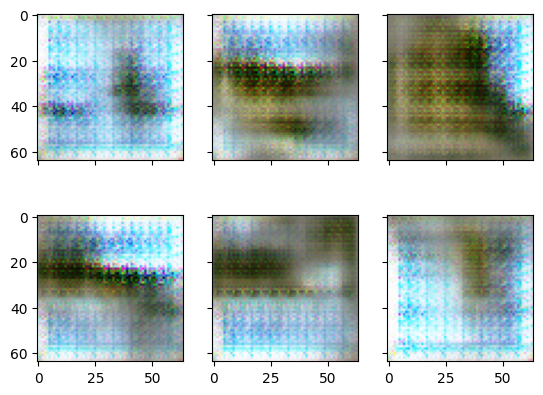

In [712]:
fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
prediction = generator.predict(np.random.normal(size = (6,latent_dim)))
prediction = ((prediction + 1) * 127.5).astype(np.uint8)
ax[0,0].imshow(prediction[0])
ax[0,1].imshow(prediction[1])
ax[0,2].imshow(prediction[2])
ax[1,0].imshow(prediction[3])
ax[1,1].imshow(prediction[4])
ax[1,2].imshow(prediction[5])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


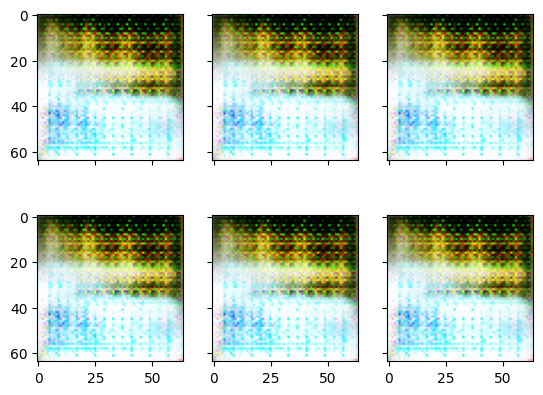

In [713]:
fig, ax = plt.subplots(2, 3, sharex = True, sharey = True)
for i in range(6):
    prediction = generator.predict(np.asarray([[2]*latent_dim]))
    ax[i // 3, i % 3].imshow(((prediction  + 1) * 127.5).astype(np.uint8)[0])
plt.show()

To evaluate the test set the .csv files must be submitted to Kaggle. Each model's predictions were saved above and manually submitted. Below you can find a screenshot of all the results.

<img src="https://github.com/chill0121/Kaggle_Projects/blob/main/Cancer_Detection_Histopathology/Models/Kaggle_Submission_Scores.png?raw=true" alt="results" width="1000"/>

###### [Back to Table of Contents](#toc)

## 7. Conclusion - Kaggle Submission Test Set <a name="conclusion"></a>

---


### 7.1. Possible Areas for Improvement <a name="improvements"></a>

- 

###### [Back to Table of Contents](#toc)

## Appendix A - Online References: <a name="appendixa"></a>

Resources that helped along the way in no particular order.

- Great tutorial for image generation using GANs https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- Starting point for DCGANs https://keras.io/examples/generative/dcgan_overriding_train_step/
- Solution to my Mode Collapse! https://arxiv.org/pdf/1810.01365

 Exported to HTML via command line using:

- `jupyter nbconvert Adversarial_Painting.ipynb --to html`
- `jupyter nbconvert Adversarial_Painting.ipynb --to html --HTMLExporter.theme=dark`

###### [Back to Table of Contents](#toc)